In the last notebook we managed to create fish objects and attributes and ran the model for only 1 fish. What we observed is that:
* Fishes can decide to sell positions while they don't know if they have some, e.g. they may choose to sell long positions but they have none. So they'll sell nothing, it's still a little thing that may give problems. I fixed self.order problems for when not doing anything.
* Looks like at the moment a bubble effect derives from big selloffs of just 1 fish, this is because randint for how many positions to liquidate is not yet set (fishes will close either all long or short positions), hey this can be an idea for creating whales and getting a wyckoff dynamic.

So in this notebook the objectives are:
* We keep fishes simple, so they will sell all of their 'long' or 'short' positions. We'll give whales the possibility of not dumping all their shares but distributing while fishes are buying --> Wyckoff Dynamic
* Implement sleep mode for fishes even when not in survive mode
* Link creation, based on limited knowledge, fishes will not blindly follow another agent's position but will be influeced (probability from trust matrix)

**After 012.creating_links.ipynb**  
* Now we're able to create social links among agents (for fishes neighbors will be chosen randomly, just like in 012 notebook).  
* Fishes will have a friend_list which they can updated after some time (random periodic behaviour, computationally efficient).  
* Fishes will have a given threshold to trusting friends and if he trust them he CAN choose to be influenced.  

Objectives for this notebooks are now:
* Implement the new network structure on the market model with only fishes.  
* Find a way to update trust matrix using agent's cash or wallet or maybe how much it is in profit or in loss.  

In [1]:
%run _config.ipynb

### Model Methods

In [2]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    alfa = model.Price * 0.01 # coefficient for price updating
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'long':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'short':
            sso += agent_orders[i]
    
    delta = alfa * (sbo - sso)
    
    model.Last_Price = model.Price
    model.Price = model.Price + delta
    
    return model.Price

In [3]:
# INIT WITH ERDOS RENYI
def get_ER_mapped_edges(N_agents, prob, labels):
    ER = nx.erdos_renyi_graph(N_agents, prob)
    list_edges = list(ER.edges())
    
    mapped_edges = list()
    for edge in list_edges:
        node1 = list(labels.keys())[list(labels.values()).index(f'fish_{edge[0]}')]
        node2 = list(labels.keys())[list(labels.values()).index(f'fish_{edge[1]}')]
        mapped_edges.append((node1, node2))
        
    return mapped_edges

### Plot Methods

In [4]:
def get_graphlabels(ordered_dict):
    inv_dict = dict(zip(ordered_dict.values(), ordered_dict.keys()))
    return inv_dict

In [5]:
def plot_graph(schedule):
    G = schedule.net
    pos = nx.spring_layout(G, k = 10)
    labels = get_graphlabels(schedule._agents)

    plt.figure(figsize=(14, 8))
    s = nx.draw_networkx_nodes(
        G,
        pos,
        node_size = 200,
        node_color = list(dict(nx.degree(G)).values()),
        alpha = 1,
        cmap = plt.cm.BuGn
    )
    
    edge_labels = {e: round(G.edges[e]['weight'], 2) for e in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 6)
    
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

    #show the colorbar on the right side
    cbar = plt.colorbar(s)
    cbar.ax.set_ylabel('Degree', size=12)

    plt.axis('off')
    plt.show();

### General Agent's Methods

In [60]:
def sample_from_dict(dic, n):
    keys = random.sample(list(dic), n)
    return {k: dic[k] for k in keys}

def get_neighbors(dict_agents, agent_id):
    dict_agents.pop(agent_id, None) # always exclude himself from the list before taking the sample
    return sample_from_dict(dict_agents, 1) # take a sample of 1 agent

In [61]:
def add_friends(dict_neighbors, self_node):
    node_neighbors = dict_neighbors.values() # e.g. [<__main__.Agent object at 0x7f64f5ca7910>, <__main__.Agent object at 0x7f64f3ca8110>]
    
    tuple_links = list()
    for neighbour_node in node_neighbors:
        tuple_links.append((self_node, neighbour_node, random.uniform(0.40, 0.60)))
    
    return tuple_links

In [62]:
def remove_friends(G, self_node, trust_thr):
    my_edges = list(G.edges(self_node, data = True))
    
    tuple_links_to_remove = list()
    for edge in my_edges:
        if edge[2]['weight'] < trust_thr: # If weight of friend is less than my desired threshold i remove him from friends list
            tuple_links_to_remove.append((self_node, edge[1]))
    
    return tuple_links_to_remove

In [63]:
def check_socials(friends_list):
    friends_positions = [ friend.position for friend in friends_list ]
    dic = Counter(friends_positions)
    max_key = max(dic, key = dic.get)
    
    return max_key # we return influence when using also the trust matrix

In [64]:
def calculate_profit(init_price, position, shares, price_today):
    # distinction on long and short positions
    if position == 'long':
        return shares * price_today
    elif position == 'short':
        return shares * (2 * init_price - price_today)

In [65]:
def update_wealth(cash, wallet, price_today):
    # wallet is a dic {'step_0': [init_price, position, quantity], 'step_1': [...], ...}
    # for each key one wants to calculate profit now by 
    balance = 0
    keys = list(wallet.keys())
    for key in keys:
        balance += calculate_profit(wallet[key][0], wallet[key][1], wallet[key][2], price_today)
        
    return cash + balance

### Fish Agent

In [66]:
def add_new_order(wallet, step, price, position, order):
    # wallet is a dictionary {'step': [price, position, order]}
    wallet |= {f'step_{step}': [price, position, order]}
    return wallet

In [67]:
def remove_orders(wallet, cash, price_today, n_orders, positions_to_sell):
    l = list()
    cash_out = 0; shares = 0
    for key, value in wallet.items():
        if value[1] == positions_to_sell:
            l.append(key)
            # calculate profit and add to cash for that key
            cash_out += calculate_profit(value[0], value[1], value[2], price_today)
            shares += value[2]
            
    cash += cash_out # convert position in cash and delete key from positions book
    for key in l:
        del wallet[key]
    
    return wallet, cash, shares

In [68]:
class Fish(mesa.Agent):
    def __init__(self, unique_id, model, init_cash):
        super().__init__(unique_id, model)
        
        # ID's
        self.type = 'fish'
        self.unique_id = unique_id
        self.node_id = None
        
        # Agent
        #self.cash = round(init_cash * ( 1. + 0.1 * random.uniform(-1, 1) ), 2)
        self.cash = init_cash
        self.wallet = dict()
        self.wealth = self.cash
        self.trust_thr = 0.50
        
        self.position = 'null'
        self.order = 0
        
        # Agent's Thresholds
        self.cash_thr = 20
        self.survive_mode = False
        self.sleep_mode = True
        
        # Knowledge Base
        self.neighbors = dict()
        self.influence = str() # it's the most chosen friend's position
        self.Price = None
        
    # ~-~-~-~-~-~-~-~- functions ~-~-~-~-~-~-~-~-
    
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'long'
            self.order = 1
        else:
            self.position = 'short'
            self.order = 1
            
    def buy_position(self):
        if len(list(self.neighbors.keys())) > 0 and random.uniform(0, 1) < 0.5 and self.influence != 'null': # If fish has friends then can be influenced with 50% prob
            self.position = self.influence
            self.order = 1
        else:
            self.rnd_trade()
            
        self.wallet = add_new_order(self.wallet, step, self.Price, self.position, self.order)
        self.cash = self.cash - self.order * self.Price
        
    def sell_positions(self): # Note that positions is plural and for buy_position NOT
        self.position = random.choice(['long', 'short'])
        self.wallet, self.cash, self.order = remove_orders(self.wallet, self.cash, self.Price, random.randint(1, 2), self.position)
        
    # ~-~-~-~-~-~-~-~- see, next, action ~-~-~-~-~-~-~-~-
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        self.neighbors = get_neighbors(self.model.schedule._agents.copy(), self.unique_id) # for linking
        
    def _next(self):
        # Check if i'm in danger
        self.survive_mode = False if self.cash > self.cash_thr else True
        
        # Update friends_list periodically (which means not really periodically but who knows what goes in an agent's head lol)
        if random.uniform(0, 1) < 0.20:
            self.model.schedule.net.remove_edges_from(remove_friends(self.model.schedule.net.copy(), self.node_id, self.trust_thr)) # Rimuovi Amicizia
            self.model.schedule.net.add_weighted_edges_from(add_friends(self.neighbors, self.node_id)) # Aggiungi Amico
            
        # Check his friends activity, there may be friends who still didn't open any position, and some who did
        if len(list(self.neighbors.keys())) > 0: # check friends activity only if i have friends
            self.influence = check_socials(list(self.neighbors.values()))
        
    def _action(self):
        # today fish should only decide to buy or to sell positions, no both, otherwise it's a mess
        if self.survive_mode == False: # Operate normally
            if random.uniform(0, 1) < 0.5:
                self.buy_position()
            else:
                self.sell_positions()
        else: # Go for selloffs
            # if they are in survive_mode they can actually try to gain some cash back by selling their orders
            if random.uniform(0, 1) < 0.7:
                self.sell_positions()
                
    # ~-~-~-~-~-~-~-~- step function ~-~-~-~-~-~-~-~-
    def step(self):
        #if random.uniform(0, 1.0) < 0.10:
        #    self.cash += 10
        if random.uniform(0, 1) < 0.05:
            self.sleep_mode = True
        else:
            self.sleep_mode = False
        
        if self.sleep_mode == False:
            self._see()
            self._next()
            self._action()
        self.wealth = update_wealth(self.cash, self.wallet, self.Price) # this is the method that sums up cash and wallet based on cash today

In [69]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Fishes
        N_fishes = N_agents
        init_cash = 400
        
        for a in range(N_fishes):
            unique_id = f'fish_{a}'
            ag = Fish(unique_id, self, init_cash)
            self.schedule.add(ag)
                
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'cash': 'cash',
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
        # Network initialization with Erdos Renyi
        self.schedule.net.add_edges_from(
            get_ER_mapped_edges(
                self.N_agents,
                0.05,
                get_graphlabels(self.schedule._agents)
            )
        )
        
        # Init also weights to random ones
        for (u, v) in self.schedule.net.edges():
            self.schedule.net.edges[u, v]['weight'] = random.uniform(0, 1)
        
        print('Init Network')
        plot_graph(self.schedule)
        
    def step(self): 
        for i in range(self.N_agents): # Before the day starts reset all positions to null
            vars(self.schedule.agents[i])['position'] = 'null'
            
        #step the groups and agents
        self.schedule.step()
        
        #plot_graph(self.schedule)
        
        # Collect data at that timestep
        self.datacollector.collect(self)

Init Network


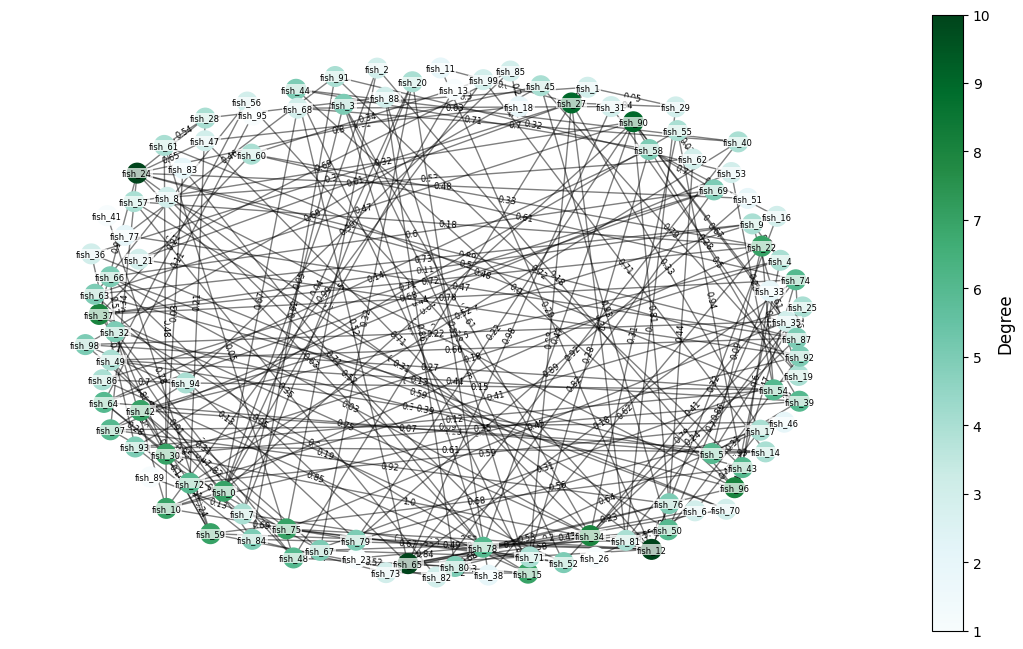

In [74]:
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 100, Price = 10)
    
    N_steps = 2000
    for step in range(N_steps):
        model.step()

In [75]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

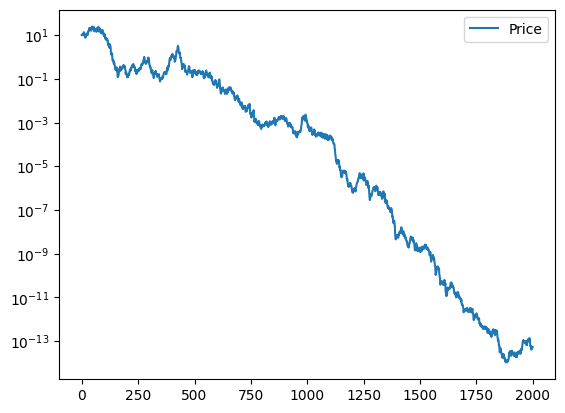

In [76]:
model_vars.plot();
plt.yscale('log')

In [73]:
model_vars.to_csv('model_vars.csv')
agent_vars.to_csv('agent_vars.csv')

**Observations:**
* We implemented the network structure with no weights updating and we see that the social network tends to a directed graph. This may be the cause of the prices falling down to $10^{-13}$.